In [2]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
import exspy
sys.path.append('..')
from util.eels import power_fit, eels_get_nearest_index
import util.crop


### EELS fitting using Power Law

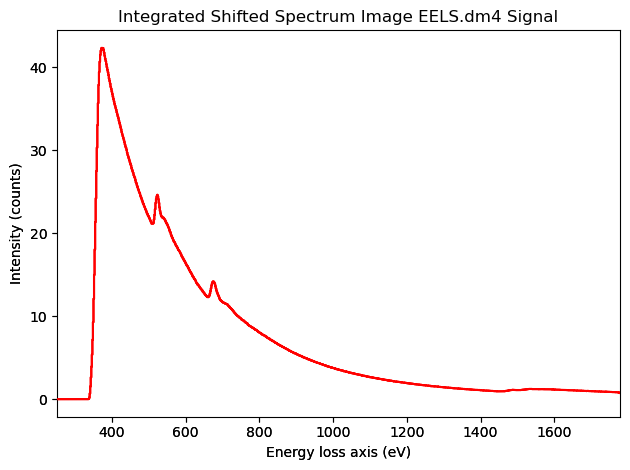

In [3]:
s = hs.load('../data/images/Jaume LFO EELS/EEL SI 22 13/Integrated Shifted Spectrum Image EELS.dm4')
s_haadf = hs.load('../data/images/Jaume LFO EELS/EEL SI 22 13/Integrated Shifted Spectrum Image adf.dm3')

left_bound = 0 # TUNE THIS
right_bound = 185 # TUNE THIS
start_pixel = 20 # TUNE THIS
end_pixel = 235 # TUNE THIS

s = s.inav[left_bound:right_bound, start_pixel:end_pixel]
s_haadf = s_haadf.isig[left_bound:right_bound, start_pixel:end_pixel]

s_mean = s.mean(axis=(0, 1))
s_mean.plot()

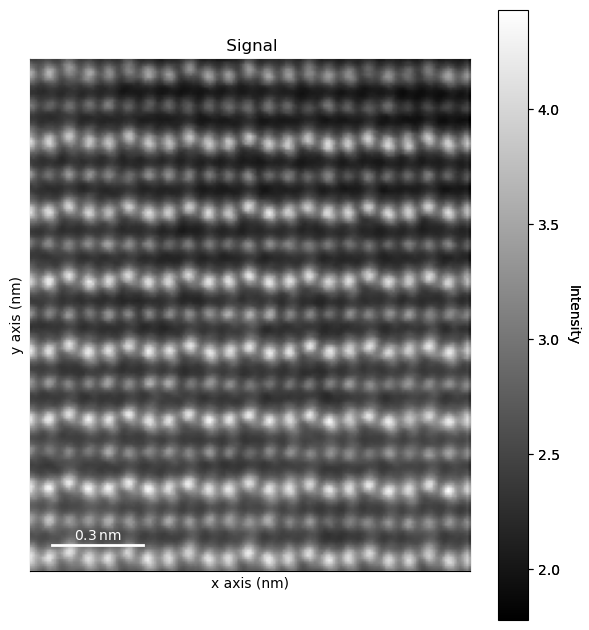

In [4]:
s_haadf.plot()

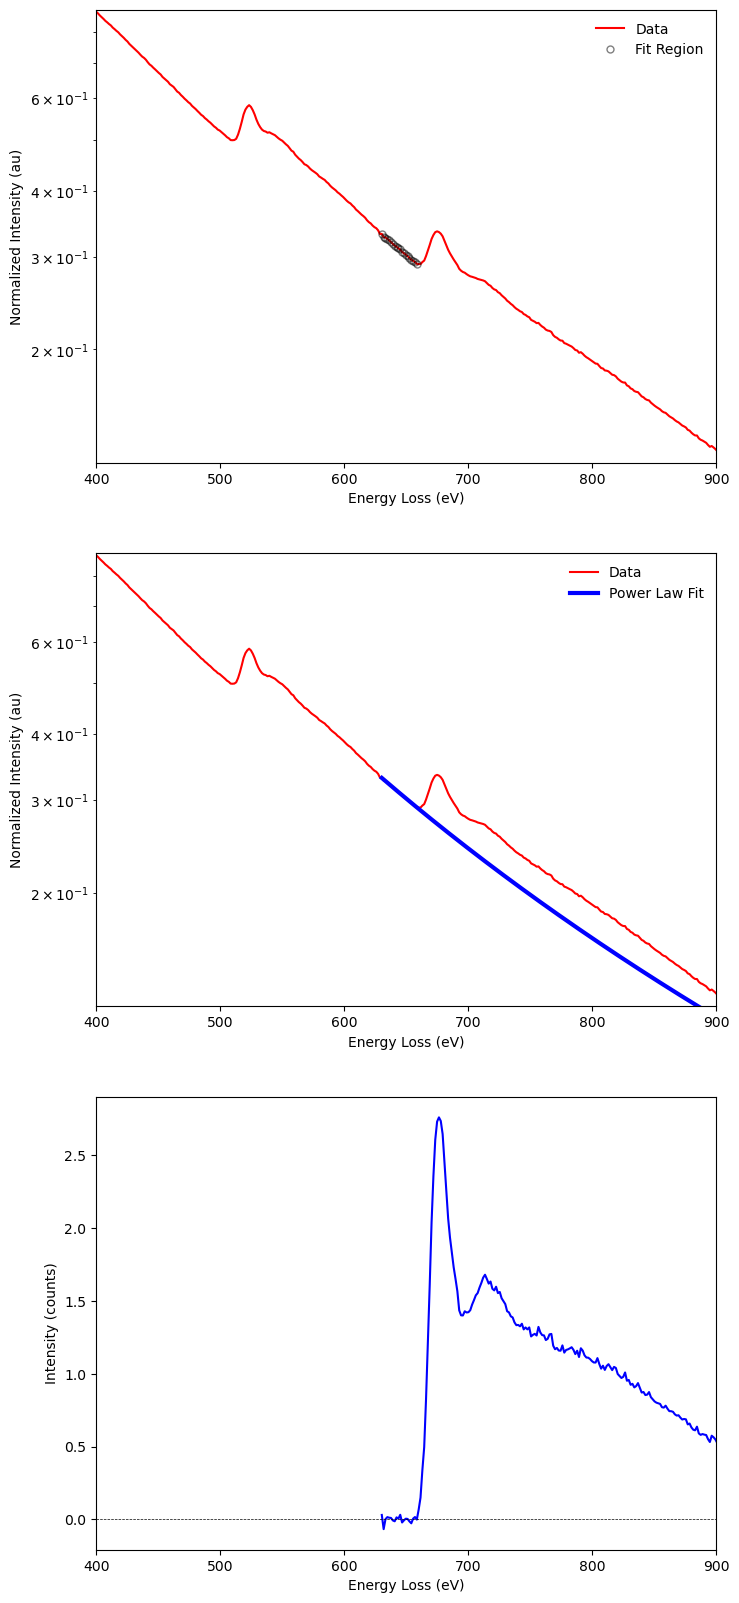

In [9]:
# O:
# fit_ranges = [[450, 510]]
# plot_range = [370, 700]
# Fe:
fit_ranges = [[630, 660]]
plot_range = [400, 900]
# Lu:
# fit_ranges = [[1300, 1450]]
# plot_range = [1200, 1800]

fitted_energy, fitted_intensity, fitted_background = power_fit(s_mean, fit_ranges, get_plot=True, plot_range=plot_range)

Labeled black points give intended integration ranges.

In [5]:
# Fe:
fit_ranges = [[600, 660]]
plot_range = [500, 900]

fitted_energy, fitted_intensity, fitted_background = power_fit(s_mean, fit_ranges, get_plot=False, plot_range=plot_range)

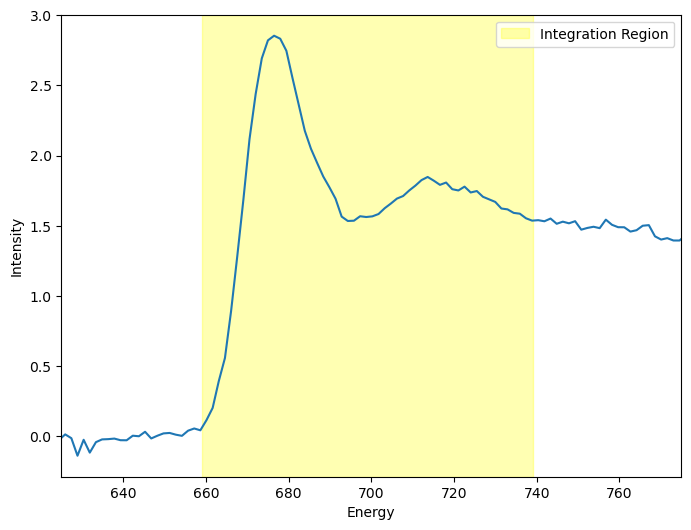

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fitted_energy, fitted_intensity)

integrate_ranges = [659, 739]

# Shade the region between the two points
ax.axvspan(integrate_ranges[0], integrate_ranges[1],
           color='yellow', alpha=0.3, label='Integration Region')

ax.set_xlim(625, 775)
ax.set_xlabel("Energy")          # Optional: nice axis label
ax.set_ylabel("Intensity")       # Optional
ax.legend()
plt.show()

In [7]:
# Lu:
fit_ranges = [[1300, 1450]]
plot_range = [1200, 1800]

fitted_energy, fitted_intensity, fitted_background = power_fit(s_mean, fit_ranges, get_plot=False, plot_range=plot_range)

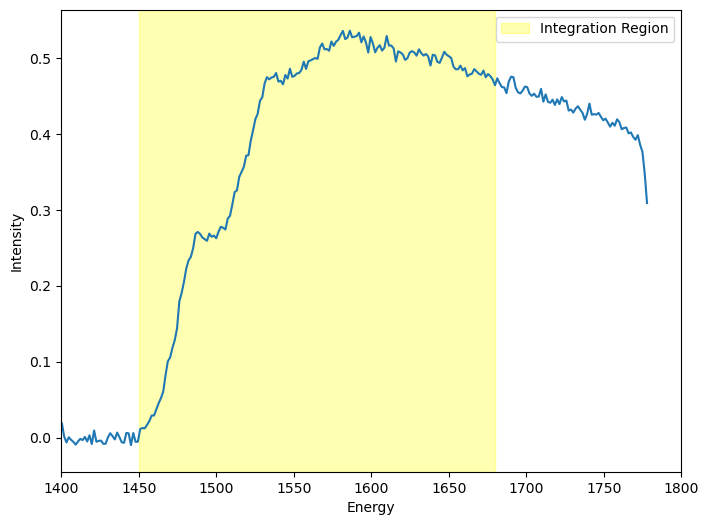

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fitted_energy, fitted_intensity)
integrate_ranges = [1450, 1680]
# Shade the region between the two points
ax.axvspan(integrate_ranges[0], integrate_ranges[1],
           color='yellow', alpha=0.3, label='Integration Region')

ax.set_xlim(1400, 1800)
ax.set_xlabel("Energy")          # Optional: nice axis label
ax.set_ylabel("Intensity")       # Optional
ax.legend()
plt.show()

### EELS Mapping

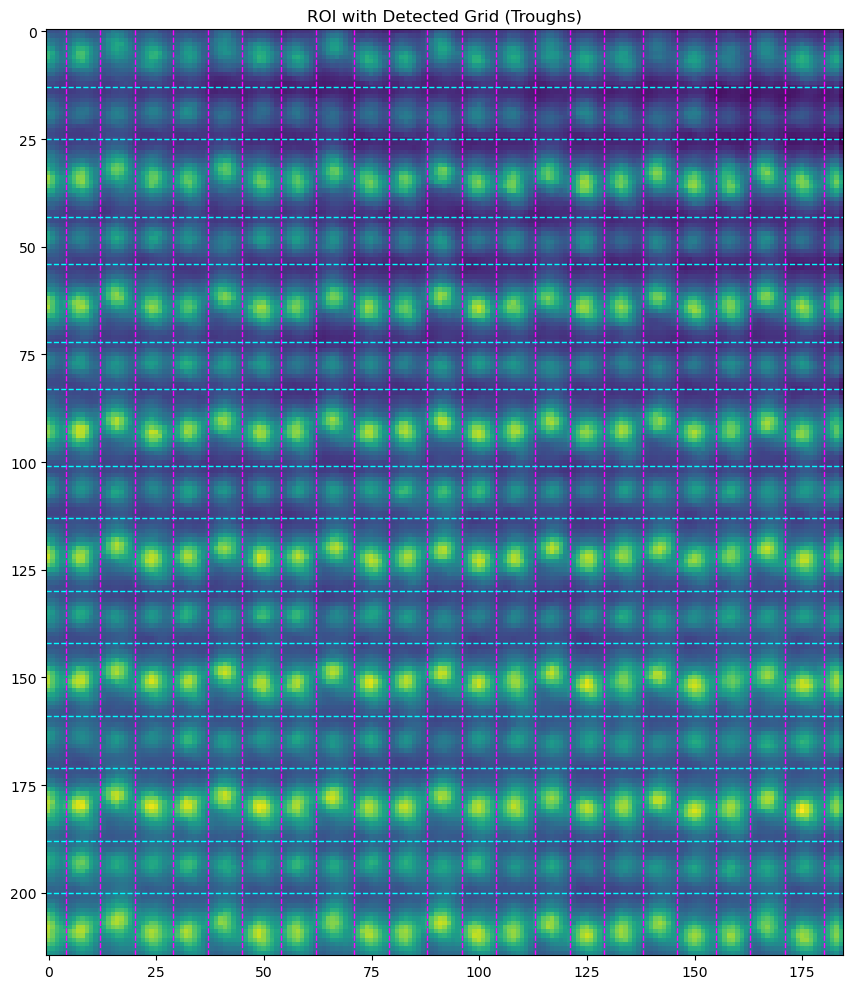

In [9]:
crop = util.crop.Crop(s_haadf)
crop.get_horizontal_peaks(get_plot=False)
crop.get_vertical_peaks(get_plot=False)
crop.build_grid_dict()
crop.plot_grid_troughs()

In [10]:
energy = s_mean.axes_manager.signal_axes[0].axis
# Fe
fit_ranges_Fe = [[600, 660]]
integrate_ranges_Fe = [659, 739]

# Lu
fit_ranges_Lu = [[1300, 1450]]
integrate_ranges_Lu = [1450, 1680]


for patch in crop.grid.values():
    left_bound = patch.roi_col_edges[0]
    right_bound = patch.roi_col_edges[1]
    start_pixel = patch.roi_row_edges[0]
    end_pixel = patch.roi_row_edges[1]
    s_patch = s.inav[left_bound:right_bound, start_pixel:end_pixel].mean(axis=(0, 1))
    
    # Fe
    fitted_energy_Fe, fitted_intensity_Fe, fitted_background_Fe = power_fit(s_patch, fit_ranges_Fe, get_plot=False)
    fit_ranges_Fe_first_idx = eels_get_nearest_index(energy, fit_ranges_Fe[0][0])
    integrate_ranges_Fe_idx = [eels_get_nearest_index(energy, integrate_ranges_Fe[0]), 
                            eels_get_nearest_index(energy, integrate_ranges_Fe[1])] - fit_ranges_Fe_first_idx

    patch_intensity_Fe = s_patch.data[fit_ranges_Fe_first_idx:] - fitted_background_Fe
    patch.integrated_intensity_Fe = np.mean(patch_intensity_Fe[integrate_ranges_Fe_idx[0]:integrate_ranges_Fe_idx[1]])

    # Lu
    fitted_energy_Lu, fitted_intensity_Lu, fitted_background_Lu = power_fit(s_patch, fit_ranges_Lu, get_plot=False)
    fit_ranges_Lu_first_idx = eels_get_nearest_index(energy, fit_ranges_Lu[0][0])
    integrate_ranges_Lu_idx = [eels_get_nearest_index(energy, integrate_ranges_Lu[0]), 
                            eels_get_nearest_index(energy, integrate_ranges_Lu[1])] - fit_ranges_Lu_first_idx

    patch_intensity_Lu = s_patch.data[fit_ranges_Lu_first_idx:] - fitted_background_Lu
    patch.integrated_intensity_Lu = np.mean(patch_intensity_Lu[integrate_ranges_Lu_idx[0]:integrate_ranges_Lu_idx[1]])
    

In [11]:
# Plot eels for each pixel

integrated_intensity_Fe_map = np.zeros(s.data.shape[:2])
integrated_intensity_Lu_map = np.zeros(s.data.shape[:2])

for i in range(s.data.shape[0]):     # row
    for j in range(s.data.shape[1]): # col
        s_pixel = s.inav[j, i]
        s_pixel_data = s_pixel.data

        # Fe
        fitted_energy_Fe, fitted_intensity_Fe, fitted_background_Fe = power_fit(s_pixel, fit_ranges_Fe, get_plot=False)
        fit_ranges_Fe_first_idx = eels_get_nearest_index(energy, fit_ranges_Fe[0][0])
        integrate_ranges_Fe_idx = [eels_get_nearest_index(energy, integrate_ranges_Fe[0]), 
                                eels_get_nearest_index(energy, integrate_ranges_Fe[1])] - fit_ranges_Fe_first_idx
        pixel_intensity_Fe = s_pixel_data[fit_ranges_Fe_first_idx:] - fitted_background_Fe
        integrated_intensity_Fe_map[i, j] = np.sum(
            pixel_intensity_Fe[integrate_ranges_Fe_idx[0]:integrate_ranges_Fe_idx[1]]
        )

        # Lu
        fitted_energy_Lu, fitted_intensity_Lu, fitted_background_Lu = power_fit(s_pixel, fit_ranges_Lu, get_plot=False)
        fit_ranges_Lu_first_idx = eels_get_nearest_index(energy, fit_ranges_Lu[0][0])
        integrate_ranges_Lu_idx = [eels_get_nearest_index(energy, integrate_ranges_Lu[0]), 
                                eels_get_nearest_index(energy, integrate_ranges_Lu[1])] - fit_ranges_Lu_first_idx
        pixel_intensity_Lu = s_pixel_data[fit_ranges_Lu_first_idx:] - fitted_background_Lu
        integrated_intensity_Lu_map[i, j] = np.sum(
            pixel_intensity_Lu[integrate_ranges_Lu_idx[0]:integrate_ranges_Lu_idx[1]]
        )

Text(0.5, 1.0, 'Integrated Intensity Fe Map')

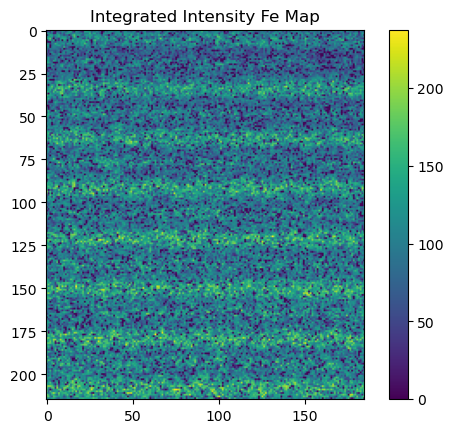

In [12]:
plt.imshow(np.where(integrated_intensity_Lu_map < 0, 0, integrated_intensity_Lu_map), cmap='viridis')
plt.colorbar()
plt.title('Integrated Intensity Fe Map')

In [13]:
for patch in crop.grid.values():
    left_bound = patch.roi_col_edges[0]
    right_bound = patch.roi_col_edges[1]
    start_pixel = patch.roi_row_edges[0]
    end_pixel = patch.roi_row_edges[1]
    
    data_Fe = np.maximum(integrated_intensity_Fe_map, 0)
    patch.integrated_intensity_Fe = np.mean(data_Fe[start_pixel:end_pixel, left_bound:right_bound])

    data_Lu = np.maximum(integrated_intensity_Lu_map, 0)
    patch.integrated_intensity_Lu = np.mean(data_Lu[start_pixel:end_pixel, left_bound:right_bound])

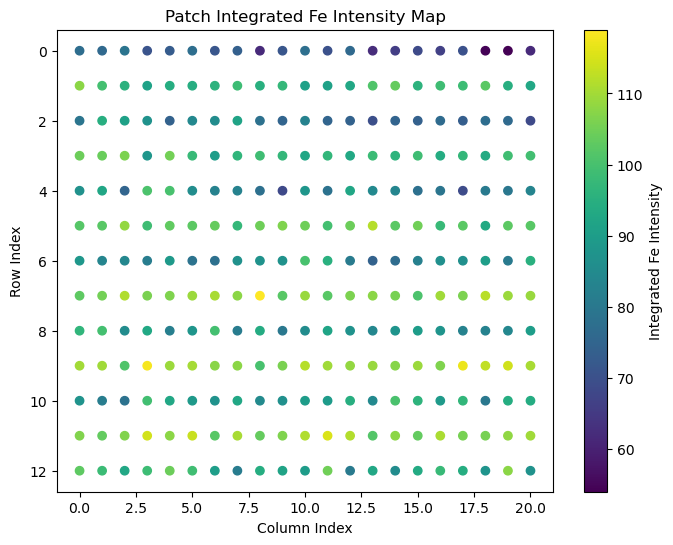

In [14]:
x = []
y = []
intensity = []

for patch in crop.grid.values():
    x.append(patch.index[0])
    y.append(patch.index[1])
    intensity.append(patch.integrated_intensity_Lu)

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=intensity, cmap='viridis')
plt.colorbar(sc, label='Integrated Fe Intensity')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Patch Integrated Fe Intensity Map')
plt.gca().invert_yaxis()
plt.show()

### Outlier Analysis

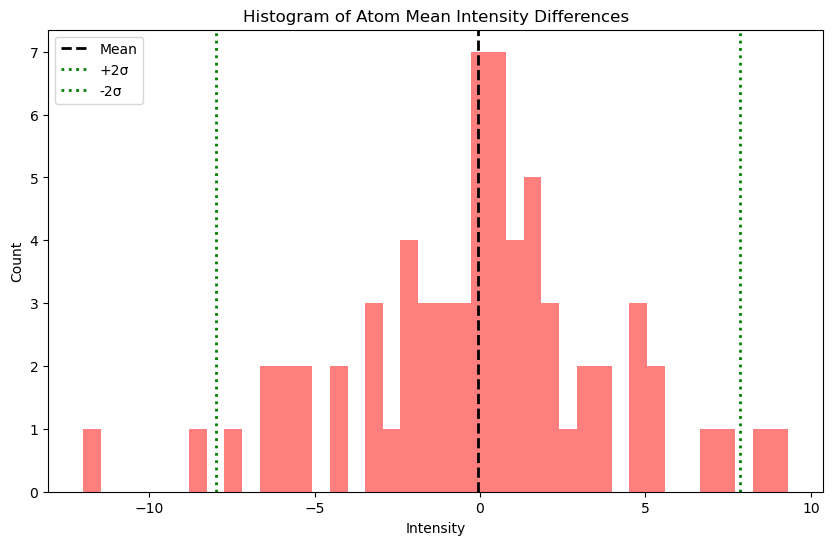

In [15]:
crop.get_atom_types()
crop.get_nn_intensities_same(horizonal_radius = 2, vertical_radius = 0, metric='eels_Lu')
# crop.get_nn_intensities_same(horizonal_radius = 2, vertical_radius = 2, metric='mean')

outlier_bar = 2
crop.get_intensity_z_score_outliers(outlier_bar=outlier_bar, atom_type='Lu', atom_selection='same')
crop.plot_intensity_outliers_z_score_histogram(outlier_bar=outlier_bar)

/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_78314/1965050144.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


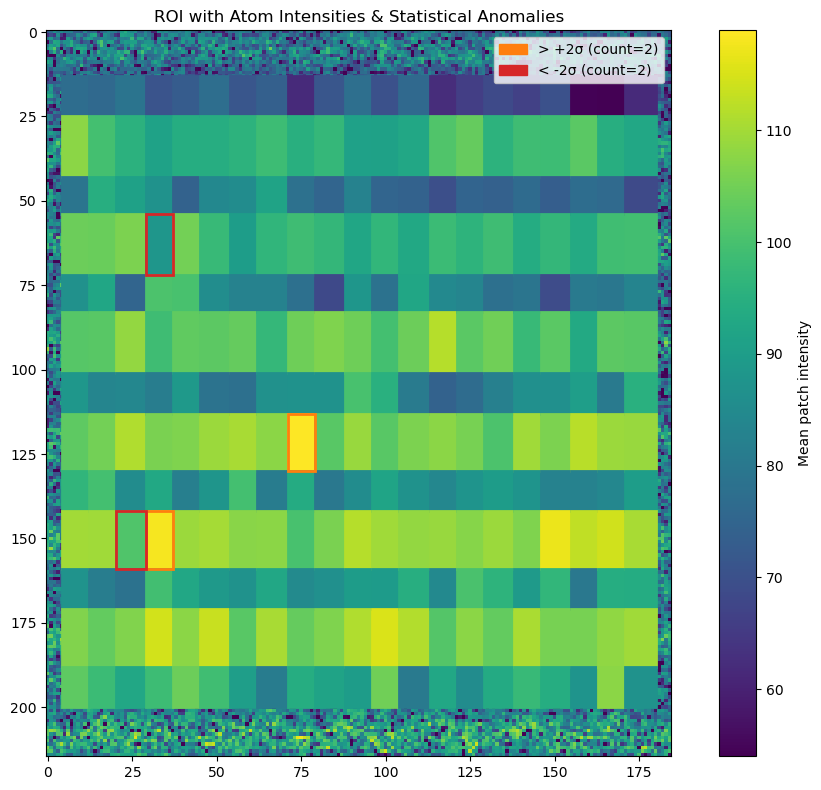

In [16]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
# ax.imshow(crop.roi)
plt.imshow(np.where(integrated_intensity_Lu_map < 0, 0, integrated_intensity_Lu_map))

# mean_intensity = [patch.mean_intensity for patch in crop.grid.values()]
# norm = mcolors.Normalize(vmin=min(mean_intensity), vmax=max(mean_intensity))
integrated_intensities_Lu = [patch.integrated_intensity_Lu for patch in crop.grid.values()]
norm = mcolors.Normalize(vmin=min(integrated_intensities_Lu), vmax=max(integrated_intensities_Lu))
cmap = cm.get_cmap('viridis')

above_color='#FF7F0E'
below_color='#D62728' 

def _get_edges(patch):
    col_edges = patch.roi_col_edges
    row_edges = patch.roi_row_edges
    x0, x1 = float(col_edges[0]), float(col_edges[1])
    y0, y1 = float(row_edges[0]), float(row_edges[1])
    return x0, x1, y0, y1

def _draw_box(patch, color, fill, z):
    edges = _get_edges(patch)
    if edges is None:
        return
    x0, x1, y0, y1 = edges
    wr = x1 - x0
    hr = y1 - y0

    # Draw box (semi-transparent fill to see the atom)
    rect = Rectangle((x0, y0), wr, hr, edgecolor=color, fill=fill, linewidth=2, facecolor=color, zorder=z)
    ax.add_patch(rect)

for patch in crop.grid.values():
    # _draw_box(patch, color=cmap(norm(patch.mean_intensity)), fill=True, z=1)
    _draw_box(patch, color=cmap(norm(patch.integrated_intensity_Lu)), fill=True, z=1)

# Draw ABOVE
for (i, j) in crop.intensity_from_vincinity_outliers_above:
    patch = crop.grid[i, j]
    _draw_box(patch, color=above_color, fill=False, z=3)

# Draw BELOW
for (i, j) in crop.intensity_from_vincinity_outliers_below:
    patch = crop.grid[i, j]
    _draw_box(patch, color=below_color, fill=False, z=3)

count_above = len(crop.intensity_from_vincinity_outliers_above)
count_below = len(crop.intensity_from_vincinity_outliers_below)

above_proxy  = Rectangle((0, 0), 1, 1, edgecolor=above_color,  facecolor=above_color)
below_proxy = Rectangle((0, 0), 1, 1, edgecolor=below_color, facecolor=below_color)
ax.legend(
    [above_proxy, below_proxy],
    [f"> +{outlier_bar}σ (count={count_above})",
     f"< -{outlier_bar}σ (count={count_below})"],
    loc="best"
)

ax.set_title('ROI with Atom Intensities & Statistical Anomalies')
# ax.set_title('ROI with Atom Intensities')

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array(mean_intensity)
sm.set_array(integrated_intensities_Lu)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Mean patch intensity")

plt.tight_layout()
plt.show()

In [17]:
_ = crop.get_intensity_outliers_isoforest(atom_type='Fe')


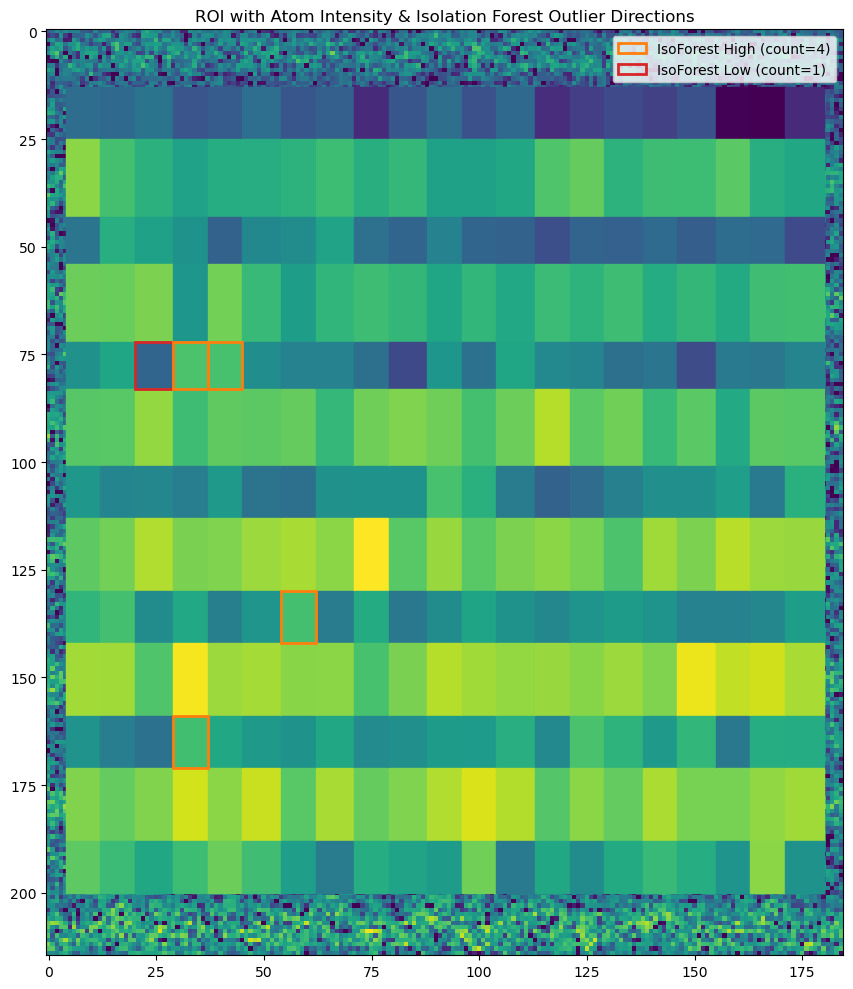

In [18]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(crop.roi)
plt.imshow(np.where(integrated_intensity_Lu_map < 0, 0, integrated_intensity_Lu_map))

# Draw intensity grid (filled rectangles)
for patch in crop.grid.values():
    # color = cmap(norm(patch.mean_intensity))
    color = cmap(norm(patch.integrated_intensity_Lu))
    x0, x1 = patch.roi_col_edges
    y0, y1 = patch.roi_row_edges
    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=color, facecolor=color, fill=True, zorder=1)
    ax.add_patch(rect)

# Define colors for directions
high_color='#FF7F0E'
low_color='#D62728' 

# Overlay Isolation Forest outliers by direction
for patch in crop.grid.values():
    x0, x1 = patch.roi_col_edges
    y0, y1 = patch.roi_row_edges
    if hasattr(patch, 'iforest_direction'):
        if patch.iforest_direction == 'high':
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=high_color, fill=False, linewidth=2, zorder=3)
            ax.add_patch(rect)
        elif patch.iforest_direction == 'low':
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=low_color, fill=False, linewidth=2, zorder=3)
            ax.add_patch(rect)

count_above = len(crop.iforest_outliers_high)
count_below = len(crop.iforest_outliers_low)

high_proxy = Rectangle((0, 0), 1, 1, edgecolor=high_color, facecolor='none', linewidth=2)
low_proxy = Rectangle((0, 0), 1, 1, edgecolor=low_color, facecolor='none', linewidth=2)
ax.legend(
    [high_proxy, low_proxy],
    [f"IsoForest High (count={count_above})",
     f"IsoForest Low (count={count_below})"],
    loc="best"
)

ax.set_title('ROI with Atom Intensity & Isolation Forest Outlier Directions')
plt.tight_layout()
plt.show()